In [9]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

In [10]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')

In [11]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [12]:
output_path = "./output/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

In [13]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [15]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [16]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

n_clusters: 2 silhouette_avg: 0.45927265


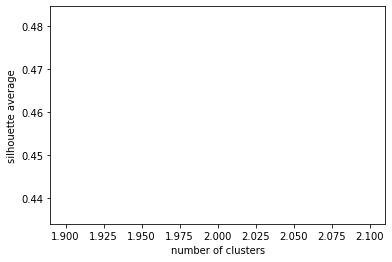

In [21]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=50 
step=100 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

In [23]:
number_of_clusters =  10
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 9    11
1    11
8    14
3    16
7    17
6    17
5    17
0    20
4    21
2    41
Name: label_kmedoids, dtype: int64


In [24]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

In [25]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

/Users/yaozheng/anaconda3/lib/python3.6/site-packages/umap/umap_.py:1157: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


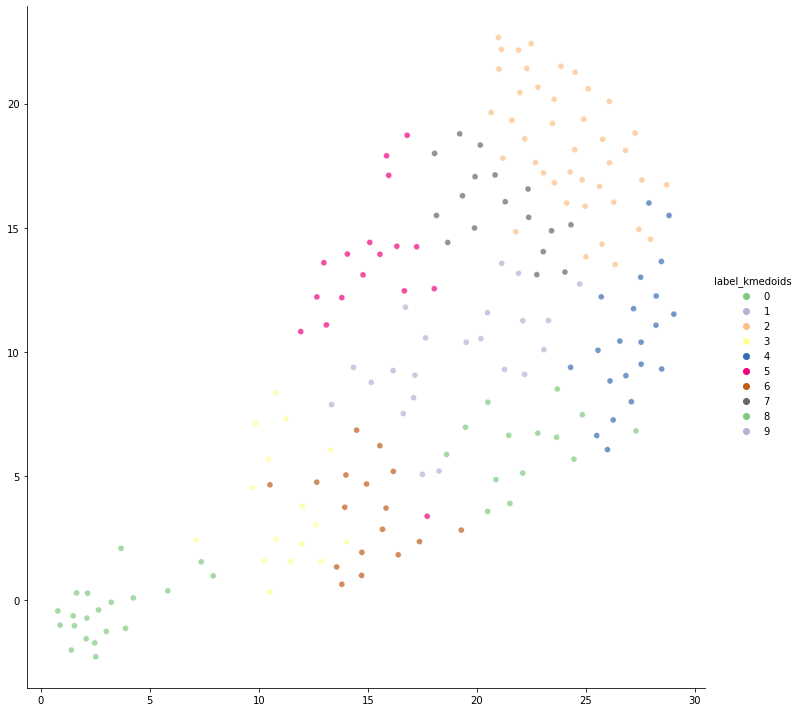

In [44]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "Accent" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.7 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)

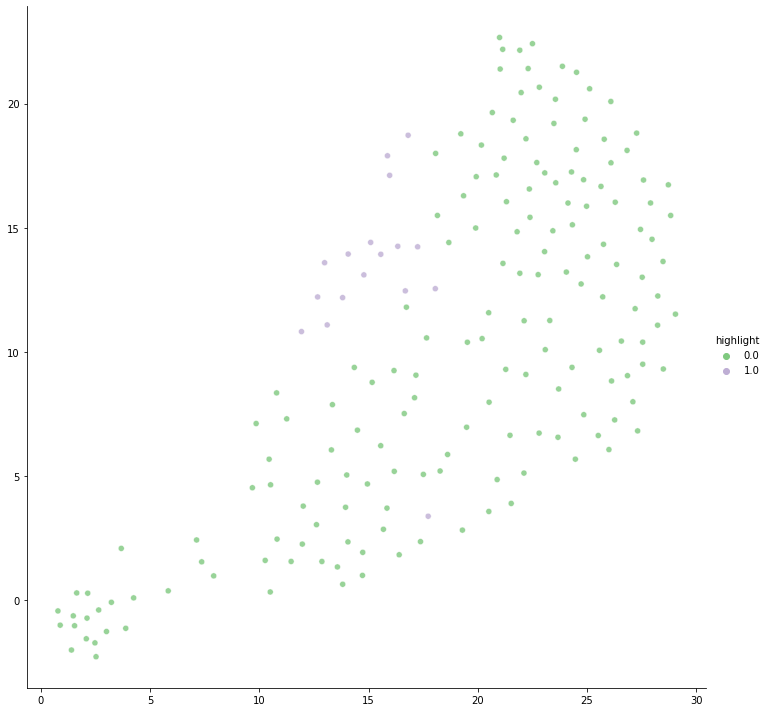

In [48]:
## Choose a cluster to higlight:
cluster_num = 5

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)

In [49]:
# print the medoids 
data.iloc[medoids_indices]

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
42,2019-10-01 05:28:48,Ruolan Xiong,德国人就是这副死德行，你有啥辙？,1,德国人就是这副死德行，你有啥辙？\n\n,-1,0,5.960464e-08,0.0
120,2020-07-17 00:02:07,Ceres Station,"@MrStig691 ""far greater control"" on population? I think you'd be pleased to know that they've already done that. With the one child policy which was criticised by most of the Western nations.",1,"@MrStig691 ""far greater control"" on population? I think you'd be pleased to\nknow that they've already done that. With the one child policy which was\ncriticised by most of the Western nations.\n\n",-1,1,0.000000e+00,0.0
82,2019-09-26 18:15:24,Winkus Guo,China has met the paris agreement co2 reduction goals.,1,China has met the paris agreement co2 reduction goals.\n\n,-1,2,0.000000e+00,0.0
101,2019-09-26 20:24:48,PointBlank00,I think that was just his accent,1,I think that was just his accent\n\n,-1,3,5.960464e-08,0.0
138,2019-09-26 12:31:14,vinm300,China is looking after itself.<br />It is spreading totalitarianism at an alarming rate.<br />Ask yourself this : do African governments want transparent democracy<br />or total surveillance corrupt totalitarianism ?<br />They will take China any day over Europe.,0,China is looking after itself. \nIt is spreading totalitarianism at an alarming rate. \nAsk yourself this : do African governments want transparent democracy \nor total surveillance corrupt totalitarianism ? \nThey will take China any day over Europe.\n\n,-1,4,0.000000e+00,0.0
70,2019-09-26 19:34:05,Kim Jong Un,Is that the reason you don’t build your Berlin airport? Lol,0,Is that the reason you don’t build your Berlin airport? Lol\n\n,music,5,0.000000e+00,1.0
58,2019-09-27 08:50:23,Nehco Oahnait,Ugh troll u are literally everywhere with ur obviously propagandist profile name...,1,Ugh troll u are literally everywhere with ur obviously propagandist profile\nname...\n\n,music,6,2.980232e-07,0.0
99,2019-09-26 16:29:05,Bad Xerge,To the best of my knowledge Europe is the only continent where diesel is more popular than gasoline as fuel for cars.,0,To the best of my knowledge Europe is the only continent where diesel is more\npopular than gasoline as fuel for cars.\n\n,-1,7,0.000000e+00,0.0
53,2019-09-27 16:54:43,环球中国人民解放军 Global Chinese Army,@Dan Steven Ours is hierarchy strong and smartest rules. as long as we follow the rules we are protected,1,@ Ours is hierarchy strong and smartest rules. as long as we follow\nthe rules we are protected\n\n,-1,8,0.000000e+00,0.0
136,2019-09-26 12:40:20,S K,"@<a href=""https://www.youtube.com/watch?v=xnudgOC9D5Y&amp;t=1m37s"">1:37</a> what is jeff goldblum doing here?",0,@1:37 what is jeff goldblum doing here?\n\n,-1,9,0.000000e+00,0.0


In [30]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  20 mean distance from center:  0.003271400782978162 Proportion of replies: 60.0
1 number of samples:  11 mean distance from center:  0.00448010177933611 Proportion of replies: 72.72727272727273
2 number of samples:  41 mean distance from center:  0.008010718738660216 Proportion of replies: 41.46341463414634
3 number of samples:  16 mean distance from center:  0.005700439214706421 Proportion of replies: 50.0
4 number of samples:  21 mean distance from center:  0.004889851697953418 Proportion of replies: 33.333333333333336
5 number of samples:  17 mean distance from center:  0.005545335807255469 Proportion of replies: 29.41176470588235
6 number of samples:  17 mean distance from center:  0.004549938239506446 Proportion of replies: 52.94117647058823
7 number of samples:  17 mean distance from center:  0.0059836049331352115 Proportion of replies: 35.294117647058826
8 number of samples:  14 mean distance from center:  0.005744184818468057 Proportion of replies: 64.2857

In [32]:
# Choose a cluster to print
cluster_number =   5
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster

Number of samples in the cluster: 17
Average Distance from cluster center: 5.545335807255469e-05


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
70,2019-09-26 19:34:05,Kim Jong Un,Is that the reason you don’t build your Berlin airport? Lol,0,Is that the reason you don’t build your Berlin airport? Lol\n\n,-1.0,5,0.000000,1.0
32,2019-09-27 20:47:56,Theophilus Wahyudi,Well they finish 12 billion dollar airport in less than 4 year.. u know what i will comeback to this channel in 20 years from now to see the progress of berlin airport update or news from you guys.. what kind of heart i&#39;am,0,Well they finish 12 billion dollar airport in less than 4 year.. u know what i\nwill comeback to this channel in 20 years from now to see the progress of\nberlin airport update or news from you guys.. what kind of heart i'am\n\n,-1.0,5,0.000010,1.0
48,2019-09-27 07:29:04,Franky Alferado,"When the Germans failed to build their Berlin airport, the just felt salty at Beijing new airport and talking nonsense about CO2.",0,"When the Germans failed to build their Berlin airport, the just felt salty at\nBeijing new airport and talking nonsense about CO2.\n\n",-1.0,5,0.000010,1.0
64,2019-09-26 23:04:30,Crikey Can't,the airport used 60% natural light,0,the airport used 60% natural light\n\n,-1.0,5,0.000014,1.0
100,2019-09-26 16:00:02,Night Knight,"16 billion, not 60 billion USD, Jesus, no wonder Berlin&#39;s new airport is a nightmare, Germany can&#39;t even get a competent reporter.",0,"16 billion, not 60 billion USD, Jesus, no wonder Berlin's new airport is a\nnightmare, Germany can't even get a competent reporter.\n\n",-1.0,5,0.000016,1.0
159,2019-09-28 16:39:22,jake the snake,"@Jacob Krone The whole germany looks like a giant farmland, no skyscrapers, no modern infrastructure, no new airports, no new nothing",1,"@ The whole germany looks like a giant farmland, no skyscrapers, no\nmodern infrastructure, no new airports, no new nothing\n\n",-1.0,5,0.000023,1.0
36,2019-09-27 16:23:05,BYC,LOL that’s why you can’t finish your airport right? Pathetic western losers,0,LOL that’s why you can’t finish your airport right? Pathetic western losers\n\n,-1.0,5,0.000025,1.0
26,2019-09-28 20:07:27,Zsari Maxim,"That&#39;s a bizarre angle to attack an airport. Have to leave it to the Germans, nice spin.",0,"That's a bizarre angle to attack an airport. Have to leave it to the Germans,\nnice spin.\n\n",-1.0,5,0.000033,1.0
37,2019-09-27 15:52:49,Aussie Boy,Are you jealous because your Berlin airport was costlier and much smaller than China’s? Not to mention China is largest renewable energy provider while America is increasing CO2!!!,0,Are you jealous because your Berlin airport was costlier and much smaller than\nChina’s? Not to mention China is largest renewable energy provider while\nAmerica is increasing CO2!!!\n\n,-1.0,5,0.000044,1.0
66,2019-10-01 05:17:51,Ruolan Xiong,@Film Makers MC Williams Could you please don't take a plane any more?,1,@ Could you please don't take a plane any more?\n\n,-1.0,5,0.000051,1.0


In [37]:
#which cluster would you like to assign labels to?
cluster_number = 6
#your label
label_manual = 'music'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [38]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
58,2019-09-27 08:50:23,Nehco Oahnait,Ugh troll u are literally everywhere with ur obviously propagandist profile name...,1,Ugh troll u are literally everywhere with ur obviously propagandist profile\nname...\n\n,music,6,2.980232e-07,0.0
122,2020-01-23 06:11:58,Samuel A,@pat white Who else could utter so much nonsense in one sentence apart from a Trump supporter?,1,@ Who else could utter so much nonsense in one sentence apart from a\nTrump supporter?\n\n,music,6,7.569790e-06,0.0
117,2020-09-24 16:03:03,stephen Zhu,@Christopher man you just receive the certification of having the most retarded comment on youtube.,1,@ man you just receive the certification of having the most\nretarded comment on youtube.\n\n,music,6,1.204014e-05,0.0
12,2020-02-28 03:16:36,王学静,"Just like your brain was picked alive by us, you are now a brainless troll. Unfortunately, your brain is really useless, and there is no way to feed pigs.",1,"Just like your brain was picked alive by us, you are now a brainless troll.\nUnfortunately, your brain is really useless, and there is no way to feed pigs.\n\n",music,6,2.187490e-05,0.0
94,2019-09-28 00:34:50,Film Makers MC Williams,And there you have the real agenda.,1,And there you have the real agenda.\n\n,music,6,2.247095e-05,0.0
130,2019-09-26 13:32:06,Dear Father,What a fooking bias media,0,What a fooking bias media\n\n,music,6,2.616644e-05,0.0
132,2019-09-26 12:56:03,Sujayashree subhakanta Barik,Nonsense media 😂,0,Nonsense media 😂\n\n,music,6,2.932549e-05,0.0
115,2019-09-26 14:10:12,TT TCP,"Whatever,u live in your own country,its ur own environment.",0,"Whatever,u live in your own country,its ur own environment.\n\n",music,6,2.980232e-05,0.0
141,2019-09-27 08:09:24,Juan Guzman,Have you heard of the tale of man named Snowden?,1,Have you heard of the tale of man named Snowden?\n\n,music,6,3.206730e-05,0.0
105,2019-09-26 15:20:21,Alexis Sayegh,Another BS topic from DW.,0,Another BS topic from DW.\n\n,music,6,4.184246e-05,0.0
